In [1]:
import re
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline
import sklearn.datasets
from sklearn import preprocessing
from sklearn import model_selection

# Data loading

In [2]:
# I use the code snippet from https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm/7369986
# It read PGM image buffer string and return a numpy array
def read_pgm2(buffer, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    #with open(filename, 'rb') as f:
    #    buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    #print 'width',width, 'height', height
    
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=15#len(header)
                            ).reshape((int(height), int(width)))

In [3]:
dataset0 = sklearn.datasets.load_files('data/CroppedYale', shuffle=True)

data/CroppedYale/yaleB36/yaleB36_P00A+070E-35.pgm
34
yaleB36
2432


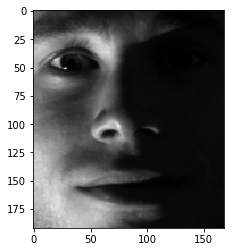

In [4]:
# Here is some sanity checks of the parsed dataset
idx0 = 10 #len(dataset0.filenames)-1
print(dataset0.filenames[idx0])
print(dataset0.target[idx0])
print(dataset0.target_names[dataset0.target[idx0]])
print(len(dataset0.filenames))
image0 = read_pgm2(dataset0.data[idx0])
plt.imshow(image0, plt.cm.gray)

In [5]:
# This cell includes the splittign of training and test set.
X = np.stack(map(read_pgm2, dataset0.data))
# X = X[:size0]

shapeX = X.shape
X = X.reshape((shapeX[0],shapeX[1]*shapeX[2]))
X = preprocessing.scale(X.astype(float),axis=1) # Mean removal and variance scaling

y = dataset0.target
enc = preprocessing.OneHotEncoder()
y = enc.fit_transform(y.reshape(-1, 1)).toarray()
# y = y.reshape(-1)
# y = y[:size0]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=42)

# Optimal Encoding

In [6]:
from networks import MLP
from OptimalEncoding import OptimalEncoding

Instructions for updating:
Use the retry module or similar alternatives.


In [7]:
import tensorflow as tf

## Classification, n_bits = math.ceil(np.log2(X.shape[0]))

In [8]:
n_in = X.shape[-1]
n_bits = math.ceil(np.log2(X.shape[0]))
n_out = y.shape[-1]
depth = 2
widths = [300, 300]

In [9]:
encoder = MLP(n_in, n_bits, depth, widths)
decoder = MLP(n_bits, n_out+1, depth, widths)

In [10]:
oe = OptimalEncoding(encoder, decoder, n_bits)

Final Loss: 9.127232


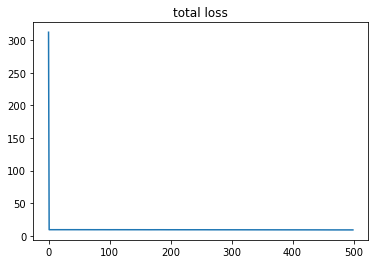

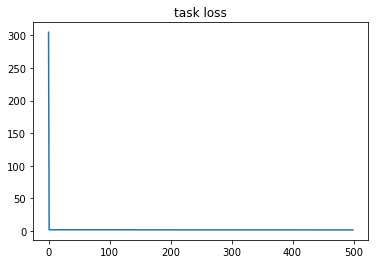

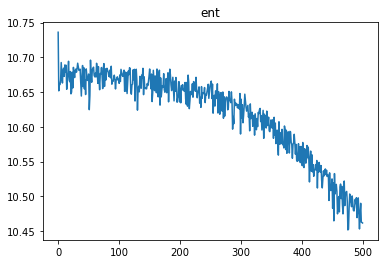

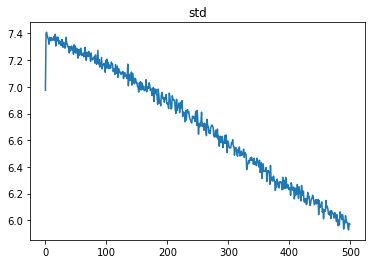

In [11]:
oe.train(X_train, y=y_train, task='classification', min_entropy=False, epochs=500, batch_size=64, lr=1e-2, tau_rate = 1e-4)

In [12]:
zhat = oe.encode(X_train)
zhard = (np.abs(zhat - 1) < .1).astype(int)
unique, counts = np.unique(zhard, axis=0,return_counts=True)
print("Used %d encodings out of a possible %d  (%.2f%%)"  %(len(unique), 2**n_bits, 100*len(unique)/float(2**n_bits)))
p = counts/np.sum(counts)
H = sum(-p*np.log2(p))
print("Used %.2f bits out of a possible %d  (%.2f%%)"  %(H, n_bits, 100*H/float(n_bits)))
print("Expected %.2f encodings out of a possible %d  (%.2f%%)"  %(2**H, 2**n_bits, 100*2**H/float(2**n_bits)))


Used 446 encodings out of a possible 4096  (10.89%)
Used 7.56 bits out of a possible 12  (63.03%)
Expected 189.14 encodings out of a possible 4096  (4.62%)


In [13]:
y_hat = oe.decode(oe.encode(X_train))
y_hat = np.argmax(oe.sess.run(tf.nn.softmax(y_hat, -1)), -1)
y_true = np.argmax(y_train, -1)
accuracy = np.mean(y_hat == y_true)
accuracy

0.0

In [14]:
y_hat = oe.decode(oe.encode(X_test))
y_hat = np.argmax(oe.sess.run(tf.nn.softmax(y_hat, -1)), -1)
y_true = np.argmax(y_test, -1)
accuracy = np.mean(y_hat == y_true)
accuracy

0.0

## Classification, n_bits = math.ceil(np.log2(y.shape[1])) 

In [15]:
n_in = X.shape[-1]
n_bits = math.ceil(np.log2(y.shape[1]))
n_out = y.shape[-1]
depth = 2
widths = [300, 300]

In [16]:
encoder = MLP(n_in, n_bits, depth, widths)
decoder = MLP(n_bits, n_out+1, depth, widths)

In [17]:
oe = OptimalEncoding(encoder, decoder, n_bits)

Final Loss: 5.791042


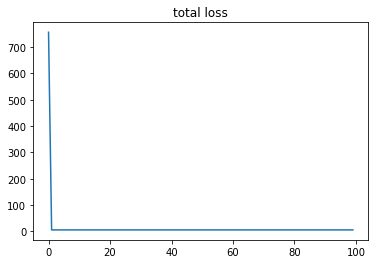

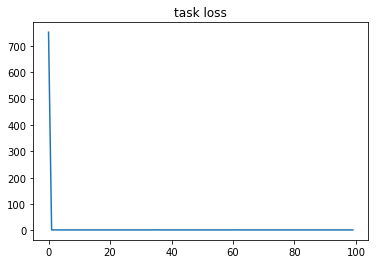

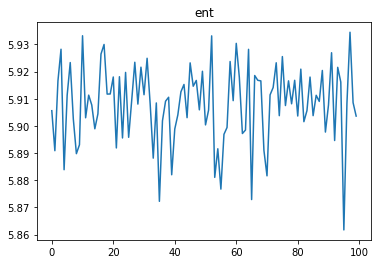

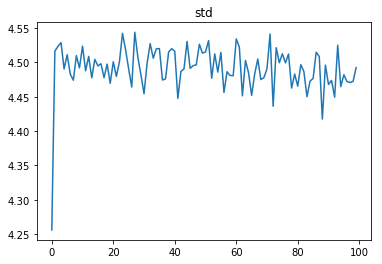

In [18]:
oe.train(X_train, y=y_train, task='classification', min_entropy=False, epochs=100, batch_size=64, lr=1e-2, tau_rate = 1e-4)

In [19]:
zhat = oe.encode(X_train)
zhard = (np.abs(zhat - 1) < .1).astype(int)
unique, counts = np.unique(zhard, axis=0,return_counts=True)
print("Used %d encodings out of a possible %d  (%.2f%%)"  %(len(unique), 2**n_bits, 100*len(unique)/float(2**n_bits)))
p = counts/np.sum(counts)
H = sum(-p*np.log2(p))
print("Used %.2f bits out of a possible %d  (%.2f%%)"  %(H, n_bits, 100*H/float(n_bits)))
print("Expected %.2f encodings out of a possible %d  (%.2f%%)"  %(2**H, 2**n_bits, 100*2**H/float(2**n_bits)))


Used 37 encodings out of a possible 64  (57.81%)
Used 3.37 bits out of a possible 6  (56.16%)
Expected 10.34 encodings out of a possible 64  (16.15%)


In [20]:
y_hat = oe.decode(oe.encode(X_train))
y_hat = np.argmax(oe.sess.run(tf.nn.softmax(y_hat, -1)), -1)
y_true = np.argmax(y_train, -1)
accuracy = np.mean(y_hat == y_true)
accuracy

0.029605263157894735

In [21]:
y_hat = oe.decode(oe.encode(X_test))
y_hat = np.argmax(oe.sess.run(tf.nn.softmax(y_hat, -1)), -1)
y_true = np.argmax(y_test, -1)
accuracy = np.mean(y_hat == y_true)
accuracy

0.024671052631578948

## Classification, yes min_ent

In [22]:
n_in = X.shape[-1]
n_bits = math.ceil(np.log2(X.shape[0]))
n_out = y.shape[-1]
depth = 2
widths = [300, 300]

In [23]:
encoder = MLP(n_in, n_bits, depth, widths)
decoder = MLP(n_bits, n_out+1, depth, widths)

In [24]:
oe = OptimalEncoding(encoder, decoder, n_bits)

In [25]:
oe.train(X_train, y=y_train, task='classification', min_entropy=True, epochs=500, batch_size=64, lr=1e-2, tau_rate = 1e-4)

KeyboardInterrupt: 

In [ ]:
zhat = oe.encode(X_train)
zhard = (np.abs(zhat - 1) < .1).astype(int)
unique, counts = np.unique(zhard, axis=0,return_counts=True)
print("Used %d encodings out of a possible %d  (%.2f%%)"  %(len(unique), 2**n_bits, 100*len(unique)/float(2**n_bits)))
p = counts/np.sum(counts)
H = sum(-p*np.log2(p))
print("Used %.2f bits out of a possible %d  (%.2f%%)"  %(H, n_bits, 100*H/float(n_bits)))
print("Expected %.2f encodings out of a possible %d  (%.2f%%)"  %(2**H, 2**n_bits, 100*2**H/float(2**n_bits)))


In [ ]:
y_hat = oe.decode(oe.encode(X_train))
y_hat = np.argmax(oe.sess.run(tf.nn.softmax(y_hat, -1)), -1)
y_true = np.argmax(y_train, -1)
accuracy = np.mean(y_hat == y_true)
accuracy

In [ ]:
y_hat = oe.decode(oe.encode(X_test))
y_hat = np.argmax(oe.sess.run(tf.nn.softmax(y_hat, -1)), -1)
y_true = np.argmax(y_test, -1)
accuracy = np.mean(y_hat == y_true)
accuracy